In [1]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from potentials import PotentialOne, PotentialTwo, PotentialOnePrime
from zv_cv import Eval_ZVCV
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q,test_traj
from optimize import Run_eval_test,optimize_parallel_new 
from utils import *
import copy

In [47]:
N_burn = 1*10**4 # Burn in period
N_train = 1*10**5 # Number of samples on which we optimize
step = 0.1 # Step size
#put 0.5 for MALA
#step = 0.2
n_traj = 96 # Number of independent MCMC trajectories for test
f_type = "sum_squared"
bn = 300
W_test = construct_ESVM_kernel(N_train,bn)

Choose density parameters

In [48]:
d = 2
B = np.pi/2
M = 10.0
Cur_pot = PotentialOne(B,M,d)
#mu = 0.5
#sigma = 0.5
#M = 1.0
#Cur_pot = PotentialTwo(M,mu,sigma,d)

### Generate data

In [49]:
sampler = {"sampler":"RWM","burn_type":"full","main_type":"full"} # Sampling method

if sampler["sampler"] == "ULA":
    res = Generate_train(n_traj, sampler, Cur_pot, step, N_burn, N_train, d)
    res = np.asarray(res)
    traj,traj_grad = res[:,0,:,:],res[:,1,:,:]
else:
    res = Generate_train(n_traj, sampler, Cur_pot, step, N_burn, N_train, d)
    traj = []
    traj_grad = []
    for i in range(len(res)):
        traj.append(res[i][0])
        traj_grad.append(res[i][1])
        print("accepted = ",res[i][2])
    traj = np.asarray(traj)
    traj_grad = np.asarray(traj_grad)

ncores =  12
accepted =  79137
accepted =  79392
accepted =  79384
accepted =  79281
accepted =  79377
accepted =  79497
accepted =  79474
accepted =  79822
accepted =  79665
accepted =  79196
accepted =  79209
accepted =  79077
accepted =  79201
accepted =  79336
accepted =  79690
accepted =  79311
accepted =  79440
accepted =  79381
accepted =  79371
accepted =  79263
accepted =  79241
accepted =  79438
accepted =  79060
accepted =  79669
accepted =  79371
accepted =  79264
accepted =  79305
accepted =  79525
accepted =  79308
accepted =  79408
accepted =  79449
accepted =  79457
accepted =  79395
accepted =  79126
accepted =  79510
accepted =  79424
accepted =  79649
accepted =  79311
accepted =  79288
accepted =  79441
accepted =  79578
accepted =  79492
accepted =  79684
accepted =  79331
accepted =  79320
accepted =  79344
accepted =  79437
accepted =  79253
accepted =  79039
accepted =  79366
accepted =  79512
accepted =  79255
accepted =  79330
accepted =  79293
accepted =  793

In [50]:
print(traj.shape)
print(traj_grad.shape)
traj_grad = (-1)*traj_grad

(96, 100000, 2)
(96, 100000, 2)


In [51]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Eval_ZVCV, [(traj[i,:,:],traj_grad[i,:,:],f_type,None,W_test) for i in range (n_traj)])
trav.close()

In [52]:
res_arr = np.asarray(res)
print(res_arr.shape)

(96, 2, 5)


### Saving results

In [53]:
np.save("rezende/rwm_quadratic_15_04.npy",res_arr)
print("Average vr rates:")
print("ZV-1:",np.mean(res_arr[:,1,0]/res_arr[:,1,1]))
print("CV-1:",np.mean(res_arr[:,1,0]/res_arr[:,1,3]))
print("ZV-2:",np.mean(res_arr[:,1,0]/res_arr[:,1,2]))
print("CV-2:",np.mean(res_arr[:,1,0]/res_arr[:,1,4]))

Average vr rates:
ZV-1: 1.003163173173597
CV-1: 1.020669706353117
ZV-2: 1.245402857617012
CV-2: 3.209768037402661


### Comparison plots

In [54]:
title = ""
labels = ['Vanilla\n RWM', 'RWM \nwith ZV-1', 'RWM \nwith CV-1']

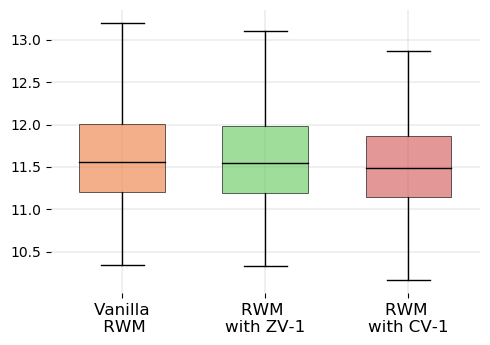

In [55]:
data = [res_arr[:,0,0],res_arr[:,0,1],res_arr[:,0,3]] 
boxplot_ind(data, title, labels)

In [56]:
title = ""
labels = ['ULA \nwith ZV-1', 'ULA \nwith CV-1']

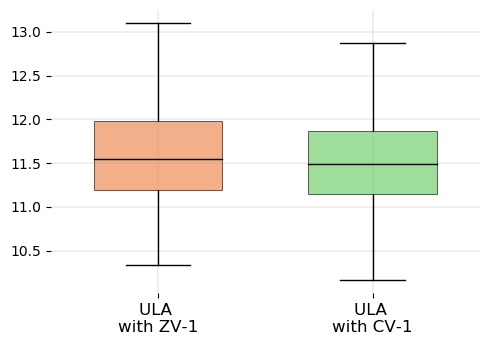

In [57]:
data = [res_arr[:,0,1],res_arr[:,0,3]] 
boxplot_ind(data, title, labels)

In [58]:
title = ""
labels = ['Vanilla\n MALA', 'MALA \nwith ZV-2', 'MALA \nwith CV-2']

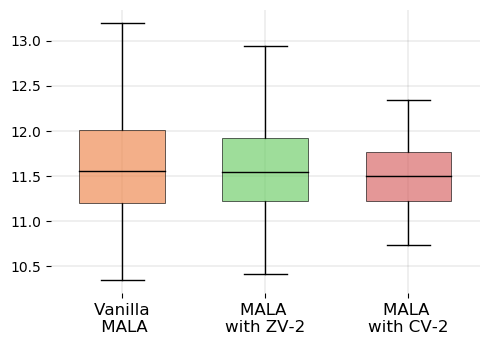

In [59]:
data = [res_arr[:,0,0],res_arr[:,0,2],res_arr[:,0,4]] 
boxplot_ind(data, title, labels)

In [60]:
title = ""
labels = ['ULA \nwith ZV-2', 'ULA \nwith CV-2']

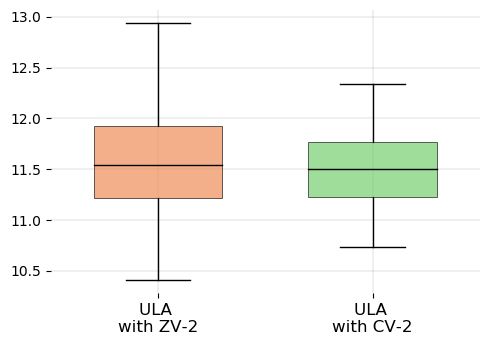

In [61]:
data = [res_arr[:,0,2],res_arr[:,0,4]] 
boxplot_ind(data, title, labels)